<a href="https://colab.research.google.com/github/bksgupta/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains all the sample code in chapter 16._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/16_nlp_with_rnns_and_attention.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [55]:
tf.__version__

'2.2.0'

In [6]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

     |████████████████████████████████| 1.1MB 2.8MB/s 
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [0]:
y2 = tf.constant([[1.]] * 32)
y2.shape

TensorShape([32, 1])

# Char-RNN

## Splitting a sequence into batches of shuffled windows

For example, let's split the sequence 0 to 14 into windows of length 5, each shifted by 2 (e.g.,`[0, 1, 2, 3, 4]`, `[2, 3, 4, 5, 6]`, etc.), then shuffle them, and split them into inputs (the first 4 steps) and targets (the last 4 steps) (e.g., `[2, 3, 4, 5, 6]` would be split into `[[2, 3, 4, 5], [3, 4, 5, 6]]`), then create batches of 3 such input/target pairs:

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))

for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  # print ('heplplow')
  print()

0 1 2 3 4 
2 3 4 5 6 
4 5 6 7 8 
6 7 8 9 10 
8 9 10 11 12 
10 11 12 13 14 


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))

for window in dataset:
  print(window.numpy())


[0 1 2 3 4]
[2 3 4 5 6]
[4 5 6 7 8]
[ 6  7  8  9 10]
[ 8  9 10 11 12]
[10 11 12 13 14]


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.map(lambda window: (window[:-1], window[1:]))

for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [1 2 3 4]
[2 3 4 5] [3 4 5 6]
[4 5 6 7] [5 6 7 8]
[6 7 8 9] [ 7  8  9 10]
[ 8  9 10 11] [ 9 10 11 12]
[10 11 12 13] [11 12 13 14]


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.map(lambda window: (window[:-1], window[1:]))
dataset = dataset.shuffle(buffer_size=15)


for x,y in dataset:
  print(x.numpy(), y.numpy())


[6 7 8 9] [ 7  8  9 10]
[2 3 4 5] [3 4 5 6]
[4 5 6 7] [5 6 7 8]
[0 1 2 3] [1 2 3 4]
[ 8  9 10 11] [ 9 10 11 12]
[10 11 12 13] [11 12 13 14]


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.map(lambda window: (window[:-1], window[1:]))
dataset = dataset.shuffle(buffer_size=15)

dataset = dataset.batch(3).prefetch(1)

for x,y in dataset:
  print(x.numpy(), y.numpy())

[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]] [[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]] [[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


In [0]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


## Loading the Data and Preparing the Dataset

In [0]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

In [0]:
filepath

'/root/.keras/datasets/shakespeare.txt'

In [0]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [0]:
print(shakespeare_text[:141])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to f


In [0]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [0]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [0]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [0]:
tokenizer.texts_to_sequences(["first"])

[[20, 6, 9, 8, 3]]

In [0]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [0]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [0]:
tokenizer.word_index

{'\n': 11,
 ' ': 1,
 '!': 31,
 '$': 39,
 '&': 38,
 "'": 28,
 ',': 18,
 '-': 32,
 '.': 27,
 '3': 37,
 ':': 24,
 ';': 29,
 '?': 30,
 'a': 5,
 'b': 22,
 'c': 19,
 'd': 13,
 'e': 2,
 'f': 20,
 'g': 21,
 'h': 7,
 'i': 6,
 'j': 33,
 'k': 25,
 'l': 12,
 'm': 15,
 'n': 10,
 'o': 4,
 'p': 23,
 'q': 34,
 'r': 9,
 's': 8,
 't': 3,
 'u': 14,
 'v': 26,
 'w': 17,
 'x': 35,
 'y': 16,
 'z': 36}

In [0]:
max_id

39

In [0]:
dataset_size

1115394

In [0]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [0]:
 np.array(tokenizer.texts_to_sequences([shakespeare_text])).shape

(1, 1115394)

In [0]:
encoded.shape

(1115394,)

In [0]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [0]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [0]:
np.random.seed(42)
tf.random.set_seed(42)

In [0]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [0]:
for window in dataset:
  print(window)
  sys.exit(12)


(<tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[18,  3,  9, ...,  6,  0,  6],
       [ 3,  0,  2, ..., 29,  0,  2],
       [15,  0, 22, ...,  9,  7, 16],
       ...,
       [ 2,  6,  5, ...,  0,  7,  2],
       [ 5,  7,  1, ..., 21,  1, 18],
       [ 5,  9, 20, ...,  3, 13, 11]])>, <tf.Tensor: shape=(32, 100), dtype=int64, numpy=
array([[ 3,  9,  2, ...,  0,  6,  1],
       [ 0,  2,  6, ...,  0,  2,  6],
       [ 0, 22,  4, ...,  7, 16,  1],
       ...,
       [ 6,  5,  7, ...,  7,  2,  4],
       [ 7,  1,  0, ...,  1, 18,  3],
       [ 9, 20,  0, ..., 13, 11, 12]])>)


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [0]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [0]:
dataset = dataset.prefetch(1)

In [0]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39) (32, 100)


## Creating and Training the Model

In [0]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     # no dropout in stateful RNN (https://github.com/ageron/handson-ml2/issues/32)
                     # dropout=0.2, recurrent_dropout=0.2,
                     ),
    keras.layers.GRU(128, return_sequences=True,
                     # dropout=0.2, recurrent_dropout=0.2
                    ),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 1524s 49ms/step - loss: 0.9546
Epoch 2/10
31370/31370 [==============================] - 1489s 47ms/step - loss: 0.9480
Epoch 3/10
31370/31370 [==============================] - 1495s 48ms/step - loss: 1.0061
Epoch 4/10
31370/31370 [==============================] - 1485s 47ms/step - loss: 1.0536
Epoch 5/10
31370/31370 [==============================] - 1463s 47ms/step - loss: 1.0875
Epoch 6/10
31370/31370 [==============================] - 1454s 46ms/step - loss: 1.1204
Epoch 7/10
31370/31370 [==============================] - 1461s 47ms/step - loss: 1.1412
Epoch 8/10
31370/31370 [==============================] - 1458s 46ms/step - loss: 1.1674
Epoch 9/10
31370/31370 [==============================] - 1445s 46ms/step - loss: 1.2030
Epoch 10/10
31370/31370 [==============================] - 1435s 46ms/step - loss: 1.2115


In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 128)         64896     
_________________________________________________________________
gru_3 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 39)          5031      
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


## Using the Model to Generate Text

In [0]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [0]:
len('You must visit Londo')

20

In [0]:
# X_new = preprocess(["How are yo"])
X_new = preprocess(["You must visit Londo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'n'

In [0]:
tokenizer.sequences_to_texts(Y_pred + 1)[0]

'  u r a a s t   b e r i t   t i v g , n'

In [0]:
tokenizer.sequences_to_texts(Y_pred + 1)

['  u r a a s t   b e r i t   t i v g , n']

In [0]:
len(tokenizer.sequences_to_texts(Y_pred + 1)[0])

39

In [0]:
X_new.shape

TensorShape([1, 20, 39])

In [0]:
check_pred = model.predict(X_new)
check_pred[0][-1]

array([2.2355400e-05, 3.1150586e-05, 3.4371214e-03, 4.0830313e-05,
       1.6731616e-03, 8.5917127e-04, 2.0516249e-03, 1.9108407e-03,
       2.0409143e-02, 9.4660854e-01, 3.2883570e-05, 1.3485111e-02,
       5.6493764e-06, 8.1276504e-04, 1.9755116e-05, 5.7846447e-03,
       6.8242924e-05, 2.3462121e-04, 1.4036143e-03, 8.8179131e-06,
       7.7532291e-05, 1.7067853e-04, 7.6053555e-05, 3.6450761e-04,
       5.2578014e-07, 1.2917679e-06, 3.5680347e-05, 1.6845026e-05,
       1.6841808e-04, 6.8145244e-05, 2.2526114e-05, 9.5832860e-05,
       1.4002430e-08, 1.9169413e-06, 6.4777644e-10, 2.6359663e-09,
       5.2519571e-15, 1.0226693e-15, 2.0357531e-15], dtype=float32)

In [0]:
np.argmax(model.predict(X_new),axis=-1)

array([[ 0, 13,  0, 12,  4,  7,  2,  0,  6,  1,  7,  5,  2,  4,  2,  5,
        25, 20,  0,  9]])

In [0]:
tokenizer.sequences_to_texts(np.argmax(model.predict(X_new),axis=-1)+1)

['  u   d a s t   h e s i t a t i v g   n']

In [0]:
np.argmax(model.predict(X_new),axis=-1)+1

array([[ 1, 14,  1, 13,  5,  8,  3,  1,  7,  2,  8,  6,  3,  5,  3,  6,
        26, 21,  1, 10]])

In [0]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [0]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]
    # return tokenizer.sequences_to_texts(char_id.numpy())

In [0]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

'u'

In [0]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [0]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

the suitors and on as comes
that and so love the gr


In [0]:
print(complete_text("t", temperature=1))

to companion, you must
and prored my entrrifury lik


In [0]:
print(complete_text("t", temperature=2))

tpent memily
meml?

proud?

b'dal! dear. ruly-haper


## Stateful RNN

In [0]:
# Trying to understand tf.stack
datasets = []
inc_dataset = tf.data.Dataset.range(10)
dec_dataset = tf.data.Dataset.range(0, -10, -1)


window_length = 5
n_steps =5

dataset = inc_dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
datasets.append(dataset)

dataset = dec_dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
datasets.append(dataset)

dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))

for val in dataset:
  print (val)

# for batch in batched_dataset.take(2):
#   print([arr.numpy() for arr in batch])


tf.Tensor(
[[ 0  1  2  3  4]
 [ 0 -1 -2 -3 -4]], shape=(2, 5), dtype=int64)
tf.Tensor(
[[ 5  6  7  8  9]
 [-5 -6 -7 -8 -9]], shape=(2, 5), dtype=int64)


In [0]:
tf.random.set_seed(42)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [0]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.repeat().map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [0]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [0]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                   callbacks=[ResetStatesCallback()])

Epoch 1/50
313/313 [==============================] - 102s 327ms/step - loss: 2.6173
Epoch 2/50
313/313 [==============================] - 103s 329ms/step - loss: 2.1763
Epoch 3/50
313/313 [==============================] - 102s 326ms/step - loss: 2.5665
Epoch 4/50
313/313 [==============================] - 100s 319ms/step - loss: 2.2085
Epoch 5/50
313/313 [==============================] - 99s 315ms/step - loss: 2.1751
Epoch 6/50
313/313 [==============================] - 99s 316ms/step - loss: 2.1157
Epoch 7/50
313/313 [==============================] - 101s 323ms/step - loss: 2.1199
Epoch 8/50
313/313 [==============================] - 100s 321ms/step - loss: 2.1141
Epoch 9/50
313/313 [==============================] - 100s 320ms/step - loss: 2.0841
Epoch 10/50
313/313 [==============================] - 101s 323ms/step - loss: 1.9925
Epoch 11/50
313/313 [==============================] - 101s 323ms/step - loss: 1.8686
Epoch 12/50
313/313 [==============================] - 101s 323ms

To use the model with different batch sizes, we need to create a stateless copy. We can get rid of dropout since it is only used during training:

In [0]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

To set the weights, we first need to build the model (so the weights get created):

In [0]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [0]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [0]:
tf.random.set_seed(42)

print(complete_text("t"))

thing chaid whose i shall not part a
king thou to m


# Sentiment Analysis

In [0]:
tf.random.set_seed(42)

You can load the IMDB dataset easily:

In [0]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 1s 0us/step


In [0]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [0]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1646592/1641221 [==============================] - 0s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [0]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7G9XHW/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7G9XHW/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete7G9XHW/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [0]:
datasets.keys()

dict_keys(['test', 'train', 'unsupervised'])

In [0]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [0]:
train_size, test_size

(25000, 25000)

In [0]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        # print("Review:", review.decode("utf-8")[:200], "...")
        print("Review:", review[:200], "...")
        print (len(review))
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting " ...
709
Label: 0 = Negative

Review: b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However ' ...
617
Label: 0 = Negative



In [0]:
X_batch.shape

TensorShape([2])

In [0]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [0]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [0]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [0]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [0]:
len(vocabulary)

53893

In [0]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [0]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [0]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [0]:
def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [0]:
for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [0]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 43s 55ms/step - loss: 0.5305 - accuracy: 0.7281
Epoch 2/5
781/781 [==============================] - 42s 54ms/step - loss: 0.3459 - accuracy: 0.8554
Epoch 3/5
781/781 [==============================] - 42s 54ms/step - loss: 0.1913 - accuracy: 0.9319
Epoch 4/5
781/781 [==============================] - 43s 55ms/step - loss: 0.1341 - accuracy: 0.9536
Epoch 5/5
781/781 [==============================] - 43s 55ms/step - loss: 0.1010 - accuracy: 0.9624


Or using manual masking:

In [0]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

Epoch 1/5
781/781 [==============================] - 43s 55ms/step - loss: 0.5426 - accuracy: 0.7155
Epoch 2/5
781/781 [==============================] - 42s 54ms/step - loss: 0.3477 - accuracy: 0.8555
Epoch 3/5
781/781 [==============================] - 42s 54ms/step - loss: 0.1749 - accuracy: 0.9371
Epoch 4/5
781/781 [==============================] - 43s 55ms/step - loss: 0.1269 - accuracy: 0.9535
Epoch 5/5
781/781 [==============================] - 42s 54ms/step - loss: 0.1068 - accuracy: 0.9605


## Reusing Pretrained Embeddings

In [0]:
tf.random.set_seed(42)

In [0]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [0]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                   dtype=tf.string, input_shape=[], output_shape=[50]),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [0]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [0]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 8s 10ms/step - loss: 0.5460 - accuracy: 0.7267
Epoch 2/5
781/781 [==============================] - 8s 10ms/step - loss: 0.5129 - accuracy: 0.7494
Epoch 3/5
781/781 [==============================] - 7s 10ms/step - loss: 0.5082 - accuracy: 0.7530
Epoch 4/5
781/781 [==============================] - 7s 9ms/step - loss: 0.5046 - accuracy: 0.7538
Epoch 5/5
781/781 [==============================] - 7s 9ms/step - loss: 0.5016 - accuracy: 0.7564


## Automatic Translation

In [0]:
tf.random.set_seed(42)

In [0]:
vocab_size = 100
embed_size = 10

In [0]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

TypeError: ignored

In [0]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [0]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

In [0]:
X.shape

(1000, 10)

In [0]:
X = np.random.randint(100, size=10*1000).reshape(1000, 10)
Y = np.random.randint(100, size=15*1000).reshape(1000, 15)
X_decoder = np.c_[np.zeros((1000, 1)), Y[:, :-1]]
seq_lengths = np.full([1000], 15)

history = model.fit([X, X_decoder, seq_lengths], Y, epochs=2)

Epoch 1/2


ValueError: ignored

### Bidirectional Recurrent Layers

In [0]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, None, 10)          660       
_________________________________________________________________
bidirectional (Bidirectional (None, None, 20)          1320      
Total params: 1,980
Trainable params: 1,980
Non-trainable params: 0
_________________________________________________________________


### Positional Encoding

In [0]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [0]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32)).numpy()
PE.shape

(1, 201, 512)

In [0]:
PE.shape[-2]

201

In [0]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

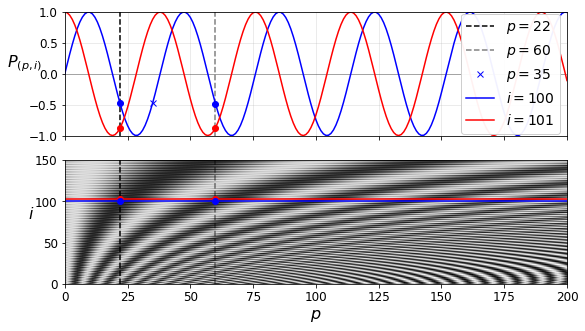

In [0]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.savefig("positional_embedding_plot")
plt.show()

In [0]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

Here is a (very) simplified Transformer (the actual architecture has skip connections, layer norm, dense nets, and most importantly it uses Multi-Head Attention instead of regular Attention):

In [0]:
Z = encoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True)([Z, Z])

encoder_outputs = Z
Z = decoder_in
for N in range(6):
    Z = keras.layers.Attention(use_scale=True, causal=True)([Z, Z])
    Z = keras.layers.Attention(use_scale=True)([Z, encoder_outputs])

outputs = keras.layers.TimeDistributed(
    keras.layers.Dense(vocab_size, activation="softmax"))(Z)

In [0]:
Z.shape

TensorShape([None, None, 512])

Here's a basic implementation of the `MultiHeadAttention` layer. One will likely be added to `keras.layers` in the near future. Note that `Conv1D` layers with `kernel_size=1` (and the default `padding="valid"` and `strides=1`) is equivalent to a `TimeDistributed(Dense(...))` layer.

In [0]:
a, b, c = [512 // 8] * 3
a,b,c

(64, 64, 64)

In [0]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [0]:
Q = np.random.rand(2, 50, 512)
V = np.random.rand(2, 80, 512)
multi_attn = MultiHeadAttention(8)
multi_attn([Q, V]).shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

In [0]:
shape = K.concatenate([K.shape(Q)[:-1], [8, -1]])
shape

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 2, 50,  8, -1], dtype=int32)>

In [0]:
b = keras.layers.Conv1D(512, kernel_size=1, use_bias=False)(Q)
b.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 50, 512])

In [0]:
c =K.reshape(b, shape)
c.shape

TensorShape([2, 50, 8, 64])

In [0]:
perm = K.permute_dimensions(c, [0, 2, 1, 3])
perm.shape

TensorShape([2, 8, 50, 64])

In [0]:
shape

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([ 2, 50,  8, -1], dtype=int32)>

In [0]:
f = K.reshape(perm, [shape[0] * 8, shape[1], -1])
f.shape

TensorShape([16, 50, 64])

In [0]:
g =tf.convert_to_tensor(np.random.rand(16, 80, 64))
g.shape

TensorShape([16, 80, 64])

In [0]:
h =tf.convert_to_tensor(np.random.rand(16, 80, 64))
h.shape

TensorShape([16, 80, 64])

In [0]:
i = keras.layers.Attention(causal=False, use_scale=False)([f,g,h])
shape_attended = K.shape(i)
shape_attended


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(3,), dtype=int32, numpy=array([16, 50, 64], dtype=int32)>

In [0]:
reshaped_attended = K.reshape(i, [shape[0], 8, shape_attended[1], shape_attended[2]])
reshaped_attended.shape

TensorShape([2, 8, 50, 64])

In [0]:
perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
perm.shape

TensorShape([2, 50, 8, 64])

In [0]:
concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
concat.shape

TensorShape([2, 50, 512])

In [0]:
#Exercise
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        # print (production)
        if isinstance(production, list):
            # print ('insie', production)
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)


In [0]:
a,b = embedded_reber_grammar[2][0]
b

4

In [0]:
embedded_reber_grammar[2][0]

([[('B', 1)],
  [('T', 2), ('P', 3)],
  [('S', 2), ('X', 4)],
  [('T', 3), ('V', 5)],
  [('X', 3), ('S', 6)],
  [('P', 4), ('V', 6)],
  [('E', None)]],
 4)

In [0]:
len(embedded_reber_grammar[2])

1

In [0]:
np.random.randint(1)

0

In [0]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")


BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [0]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")


BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

In [0]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]


In [0]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")


BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

In [0]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [POSSIBLE_CHARS.index(c)+1 for c in s]

In [0]:
string_to_ids("BTTTXXVVETE")


[1, 5, 5, 5, 7, 7, 6, 6, 2, 5, 2]

In [0]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    # X = tf.ragged.constant(all_strings, ragged_rank=1)
    X = np.array(all_strings)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [0]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)


In [0]:
X_valid.shape

(2000,)

In [0]:
X_train[12]


[1, 3, 1, 3, 6, 6, 2, 3, 2]

In [0]:
from keras.preprocessing import sequence
maxlen =50
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxlen)

In [0]:
X_train[12]


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1,
       3, 6, 6, 2, 3, 2], dtype=int32)

In [0]:
X_train.shape

(10000, 50)

In [0]:
# Could not get the ragged tensor one to work
np.random.seed(42)
tf.random.set_seed(42)
# ,mask_zero=True
tf.keras.backend.clear_session()

embedding_size = 5

model = keras.models.Sequential([
    # keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    # keras.layers.InputLayer(input_shape=[20]),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS)+1, output_dim=embedding_size,input_length=maxlen),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum = 0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
313/313 [==============================] - 4s 13ms/step - loss: 0.6899 - accuracy: 0.5231 - val_loss: 0.6801 - val_accuracy: 0.5735
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6645 - accuracy: 0.5703 - val_loss: 0.6636 - val_accuracy: 0.4605
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6506 - accuracy: 0.5782 - val_loss: 0.6435 - val_accuracy: 0.6230
Epoch 4/20
313/313 [==============================] - 4s 12ms/step - loss: 0.6342 - accuracy: 0.6000 - val_loss: 0.6195 - val_accuracy: 0.6595
Epoch 5/20
313/313 [==============================] - 4s 12ms/step - loss: 0.5905 - accuracy: 0.6527 - val_loss: 0.5477 - val_accuracy: 0.6910
Epoch 6/20
313/313 [==============================] - 4s 12ms/step - loss: 0.4961 - accuracy: 0.7474 - val_loss: 0.4760 - val_accuracy: 0.7645
Epoch 7/20
313/313 [==============================] - 4s 11ms/step - loss: 0.5335 - accuracy: 0.7017 - val_loss: 0.5496 - val_accuracy: 0.6845

In [0]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE",
                "BPBPVVEP"]
# X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)
X_test = np.array([string_to_ids(s) for s in test_strings])
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)
y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))



Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 1.97%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.90%
BPBPVVEP: 99.73%


In [0]:
y_proba.shape

(3, 1)

In [0]:
X_test.shape

(3, 50)

In [0]:
#Exercise
from datetime import date

MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y


In [8]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))


Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [9]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "01234567890, "
INPUT_CHARS

'ADFJMNOSabceghilmnoprstuvy01234567890, '

In [0]:
OUTPUT_CHARS = "0123456789-"

In [0]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [12]:
date_str_to_ids(x_example[0], INPUT_CHARS)


[7, 11, 19, 22, 11, 16, 9, 11, 20, 38, 28, 26, 37, 38, 33, 26, 33, 31]

In [13]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)


[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [0]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [0]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [16]:
len(OUTPUT_CHARS)

11

In [17]:
len(INPUT_CHARS)

39

In [18]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

In [19]:
Y_train.shape

TensorShape([10000, 10])

In [20]:
X_train.shape

TensorShape([10000, 18])

In [21]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    # keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
    keras.layers.TimeDistributed(keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")) 
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
model.summary()
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               83712     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10, 12)            133132    
Total params: 216,844
Trainable params: 216,844
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
313/313 [==============================] - 5s 15ms/step - loss: 1.7987 - accuracy: 0.3576 - val_loss: 1.3412 - val_accuracy: 0.5059
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 1.2322 - accuracy: 0.5575 - val_loss: 1.0376 - val_accuracy: 0.6284
Epoch 3/20
313/313 [==============================] - 4s 12ms/step - loss: 1.0359 - accuracy

In [22]:
"?" +OUTPUT_CHARS

'?0123456789-'

In [0]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]


In [0]:
X_new = prepare_date_strs(["October 17, 2009", "July 14, 1789"])


In [25]:
X_new.shape

TensorShape([2, 16])

In [26]:
# ids = model.predict_classes(X_new)
ids=np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)


2009-11-17
1789-07-14


In [27]:
model.predict(X_new).shape

(2, 10, 12)

In [28]:
ids.shape

(2, 10)

In [29]:
X_new = prepare_date_strs(["July 14, 1789"])
ids=np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)


1789-09-14


In [30]:
max_input_length = X_train.shape[1]
max_input_length

18

Very nice point
However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:



In [31]:
X_train.shape

TensorShape([10000, 18])

In [0]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    # ids = model.predict_classes(X)
    ids=np.argmax(model.predict(X), axis=-1)
# for date_str in ids_to_date_strs(ids):
#     print(date_str)

    return ids_to_date_strs(ids)

In [33]:
convert_date_strs(["October 17, 2020", "July 14, 1789"])


['2020-10-17', '1789-07-14']

In [34]:
Y_train.shape

TensorShape([10000, 10])

In [35]:
Y_train[:,:-1].shape

TensorShape([10000, 9])

In [0]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)


In [44]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)
tf.keras.backend.clear_session()

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.TimeDistributed(keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax"))(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))


Epoch 1/10
313/313 [==============================] - 5s 14ms/step - loss: 1.6901 - accuracy: 0.3714 - val_loss: 1.4141 - val_accuracy: 0.4604
Epoch 2/10
313/313 [==============================] - 4s 13ms/step - loss: 1.2030 - accuracy: 0.5569 - val_loss: 0.9099 - val_accuracy: 0.6772
Epoch 3/10
313/313 [==============================] - 4s 13ms/step - loss: 0.6252 - accuracy: 0.7840 - val_loss: 0.3824 - val_accuracy: 0.8748
Epoch 4/10
313/313 [==============================] - 4s 12ms/step - loss: 0.2015 - accuracy: 0.9538 - val_loss: 0.1021 - val_accuracy: 0.9877
Epoch 5/10
313/313 [==============================] - 4s 12ms/step - loss: 0.0784 - accuracy: 0.9903 - val_loss: 0.0416 - val_accuracy: 0.9980
Epoch 6/10
313/313 [==============================] - 4s 13ms/step - loss: 0.0281 - accuracy: 0.9995 - val_loss: 0.0237 - val_accuracy: 0.9995
Epoch 7/10
313/313 [==============================] - 4s 14ms/step - loss: 0.0792 - accuracy: 0.9839 - val_loss: 0.0785 - val_accuracy: 0.9857

In [45]:
a =["July 14, 1789", "May 01, 2020"]
X = prepare_date_strs_padded(a)
X.shape


TensorShape([2, 18])

In [46]:
len(X)

2

In [47]:
sos_id = len(OUTPUT_CHARS) + 1
Y_pred = tf.fill(dims=(20, 1), value=sos_id)
new_y = tf.fill(dims=(20, 1), value=sos_id)
tf.concat([Y_pred,new_y],axis=1).shape

TensorShape([20, 2])

In [0]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [49]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])


['1789-07-14', '2020-05-01']

In [56]:
X_train.shape

TensorShape([10000, 18])

In [65]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)


encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.TrainingSampler()

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings,
    initial_state=encoder_state,training=True)

Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=15,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))


Epoch 1/15
313/313 [==============================] - 16s 52ms/step - loss: 1.6781 - accuracy: 0.3686 - val_loss: 1.4553 - val_accuracy: 0.4323
Epoch 2/15
313/313 [==============================] - 16s 52ms/step - loss: 1.3487 - accuracy: 0.4810 - val_loss: 1.3328 - val_accuracy: 0.4922
Epoch 3/15
313/313 [==============================] - 16s 51ms/step - loss: 0.9136 - accuracy: 0.6702 - val_loss: 0.6337 - val_accuracy: 0.7789
Epoch 4/15
313/313 [==============================] - 17s 53ms/step - loss: 0.3886 - accuracy: 0.8795 - val_loss: 0.2011 - val_accuracy: 0.9553
Epoch 5/15
313/313 [==============================] - 16s 50ms/step - loss: 0.1233 - accuracy: 0.9792 - val_loss: 0.0671 - val_accuracy: 0.9937
Epoch 6/15
313/313 [==============================] - 16s 53ms/step - loss: 0.0592 - accuracy: 0.9938 - val_loss: 0.0356 - val_accuracy: 0.9984
Epoch 7/15
313/313 [==============================] - 16s 52ms/step - loss: 0.0217 - accuracy: 0.9996 - val_loss: 0.0176 - val_accuracy:

In [66]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])


['1789-07-14', '2020-05-01']

In [0]:
inference_sampler = tfa.seq2seq.sampler.GreedyEmbeddingSampler(
    embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
# batch_size = tf.shape(encoder_inputs)[0]

start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0,training=False)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])


In [78]:
batch_size

<tf.Tensor 'strided_slice_3:0' shape=(1,) dtype=int32>

In [115]:
sos_id

12

In [0]:
def fast_predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    print (X.shape[:1])
    # print (X.shape[:,0])
    print (tf.zeros_like(X[:, 0])+ sos_id)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [114]:
fast_predict_date_strs(["July 14, 1789", "May 01, 2020"])


(2,)
tf.Tensor([12 12], shape=(2,), dtype=int32)


['4489600631', '2903236-01']

In [127]:
import tensorflow_addons as tfa

np.random.seed(42)
tf.random.set_seed(42)

n_epochs = 20
encoder_embedding_size = 32
decoder_embedding_size = 32
units = 128

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

encoder_embeddings = keras.layers.Embedding(
    len(INPUT_CHARS) + 1, encoder_embedding_size)(encoder_inputs)

decoder_embedding_layer = keras.layers.Embedding(
    len(INPUT_CHARS) + 2, decoder_embedding_size)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)

encoder = keras.layers.LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

sampler = tfa.seq2seq.sampler.ScheduledEmbeddingTrainingSampler(
    sampling_probability=0.,
    embedding_fn=decoder_embedding_layer)
# we must set the sampling_probability after creating the sampler
# (see https://github.com/tensorflow/addons/pull/1714)
sampler.sampling_probability = tf.Variable(0.)

decoder_cell = keras.layers.LSTMCell(units)
output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell,
                                                 sampler,
                                                 output_layer=output_layer)
# if training:
final_outputs, final_state, final_sequence_lengths = decoder(decoder_embeddings,initial_state=encoder_state,training=True)
Y_proba = keras.layers.Activation("softmax")(final_outputs.rnn_output)

model = keras.models.Model(inputs=[encoder_inputs, decoder_inputs],
                           outputs=[Y_proba])
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

def update_sampling_probability(epoch, logs):
    proba = min(1.0, epoch / (n_epochs - 10))
    sampler.sampling_probability.assign(proba)

sampling_probability_cb = keras.callbacks.LambdaCallback(
    on_epoch_begin=update_sampling_probability)
history = model.fit([X_train, X_train_decoder], Y_train, epochs=n_epochs,
                    validation_data=([X_valid, X_valid_decoder], Y_valid),
                    callbacks=[sampling_probability_cb])


Epoch 1/20


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


313/313 [==============================] - 23s 75ms/step - loss: 1.6781 - accuracy: 0.3686 - val_loss: 1.4547 - val_accuracy: 0.4333
Epoch 2/20
313/313 [==============================] - 23s 75ms/step - loss: 1.3811 - accuracy: 0.4584 - val_loss: 1.2589 - val_accuracy: 0.5142
Epoch 3/20
313/313 [==============================] - 24s 76ms/step - loss: 1.0634 - accuracy: 0.6027 - val_loss: 0.8307 - val_accuracy: 0.6945
Epoch 4/20
313/313 [==============================] - 23s 74ms/step - loss: 0.6320 - accuracy: 0.7689 - val_loss: 0.4538 - val_accuracy: 0.8317
Epoch 5/20
313/313 [==============================] - 24s 76ms/step - loss: 0.3751 - accuracy: 0.8749 - val_loss: 0.2979 - val_accuracy: 0.9032
Epoch 6/20
313/313 [==============================] - 24s 76ms/step - loss: 0.2190 - accuracy: 0.9353 - val_loss: 0.1651 - val_accuracy: 0.9551
Epoch 7/20
313/313 [==============================] - 24s 76ms/step - loss: 0.1817 - accuracy: 0.9531 - val_loss: 0.1038 - val_accuracy: 0.9756
Epo

In [132]:
encoder_state[0]

<tf.Tensor 'lstm_17/Identity_1:0' shape=(None, 128) dtype=float32>

In [0]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.sampler.SampleEmbeddingSampler(
    embedding_fn=decoder_embedding_layer,
    softmax_temperature=softmax_temperature)
inference_decoder = tfa.seq2seq.basic_decoder.BasicDecoder(
    decoder_cell, inference_sampler, output_layer=output_layer,
    maximum_iterations=max_output_length)
batch_size = tf.shape(encoder_inputs)[:1]
start_tokens = tf.fill(dims=batch_size, value=sos_id)
final_outputs, final_state, final_sequence_lengths = inference_decoder(
    start_tokens,
    initial_state=encoder_state,
    start_tokens=start_tokens,
    end_token=0,training=False)

inference_model = keras.models.Model(inputs=[encoder_inputs],
                                     outputs=[final_outputs.sample_id])

In [84]:
# softmax_temperature.shape

TensorShape([])

In [0]:
def creative_predict_date_strs(date_strs, temperature=1.0):
    softmax_temperature.assign(temperature)
    X = prepare_date_strs_padded(date_strs)
    Y_pred = inference_model.predict(X)
    return ids_to_date_strs(Y_pred)

In [86]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

In [87]:
tf.random.set_seed(42)

creative_predict_date_strs(["July 14, 1789", "May 01, 2020"],
                           temperature=5.)

['7179307-16', '290040?400']

In [0]:
class DateTranslation(keras.models.Model):
    def __init__(self, units=128, encoder_embedding_size=32,
                 decoder_embedding_size=32, **kwargs):
        super().__init__(**kwargs)
        self.encoder_embedding = keras.layers.Embedding(
            input_dim=len(INPUT_CHARS) + 1,
            output_dim=encoder_embedding_size)
        self.encoder = keras.layers.LSTM(units,
                                         return_sequences=True,
                                         return_state=True)
        self.decoder_embedding = keras.layers.Embedding(
            input_dim=len(OUTPUT_CHARS) + 2,
            output_dim=decoder_embedding_size)
        self.attention = tfa.seq2seq.LuongAttention(units)
        decoder_inner_cell = keras.layers.LSTMCell(units)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            cell=decoder_inner_cell,
            attention_mechanism=self.attention)
        output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.TrainingSampler(),
            output_layer=output_layer)
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            cell=self.decoder_cell,
            sampler=tfa.seq2seq.sampler.GreedyEmbeddingSampler(
                embedding_fn=self.decoder_embedding),
            output_layer=output_layer,
            maximum_iterations=max_output_length)

    def call(self, inputs, training=None):
        encoder_input, decoder_input = inputs
        encoder_embeddings = self.encoder_embedding(encoder_input)
        encoder_outputs, encoder_state_h, encoder_state_c = self.encoder(
            encoder_embeddings,
            training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_outputs,
                       setup_memory=True)
        
        decoder_embeddings = self.decoder_embedding(decoder_input)

        decoder_initial_state = self.decoder_cell.get_initial_state(
            decoder_embeddings)
        decoder_initial_state = decoder_initial_state.clone(
            cell_state=encoder_state)
        
        if training:
            decoder_outputs, _, _ = self.decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                training=training)
        else:
            start_tokens = tf.zeros_like(encoder_input[:, 0]) + sos_id
            # print (decoder_initial_state.shape)
            decoder_outputs, _, _ = self.inference_decoder(
                decoder_embeddings,
                initial_state=decoder_initial_state,
                start_tokens=start_tokens,
                end_token=0)

        return tf.nn.softmax(decoder_outputs.rnn_output)

In [126]:
np.random.seed(42)
tf.random.set_seed(42)

model = DateTranslation()
optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=25,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))


Epoch 1/25
313/313 [==============================] - 26s 84ms/step - loss: 2.1479 - accuracy: 0.2303 - val_loss: 2.1420 - val_accuracy: 0.2169
Epoch 2/25
313/313 [==============================] - 24s 78ms/step - loss: 1.7907 - accuracy: 0.3575 - val_loss: 1.5567 - val_accuracy: 0.4229
Epoch 3/25
313/313 [==============================] - 25s 78ms/step - loss: 1.3782 - accuracy: 0.4903 - val_loss: 1.3199 - val_accuracy: 0.5127
Epoch 4/25
313/313 [==============================] - 24s 78ms/step - loss: 1.4065 - accuracy: 0.4954 - val_loss: 1.3644 - val_accuracy: 0.5118
Epoch 5/25
313/313 [==============================] - 25s 80ms/step - loss: 1.3794 - accuracy: 0.5128 - val_loss: 1.6588 - val_accuracy: 0.4959
Epoch 6/25
313/313 [==============================] - 25s 80ms/step - loss: 1.2132 - accuracy: 0.5438 - val_loss: 1.2505 - val_accuracy: 0.5248
Epoch 7/25
313/313 [==============================] - 25s 81ms/step - loss: 1.1804 - accuracy: 0.5476 - val_loss: 1.1717 - val_accuracy:

In [0]:
def fast_predict_date_strs_v2(date_strs):
    X = prepare_date_strs_padded(date_strs)
    X_decoder = tf.zeros(shape=(len(X), max_output_length), dtype=tf.int32)
    print (X_decoder)
    Y_probas = model.predict([X, X_decoder])
    # print(model.encoder_)
    print (Y_probas.shape)
    Y_pred = tf.argmax(Y_probas, axis=-1)
    return ids_to_date_strs(Y_pred)

In [121]:
OUTPUT_CHARS

'0123456789-'

In [119]:
fast_predict_date_strs_v2(["July 14, 1789", "May 01, 2020"])


tf.Tensor(
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]], shape=(2, 10), dtype=int32)
(2, 10, 12)


['1789-07-14', '2020-05-01']

In [94]:
#Studying Bahadanu attention from tensorflow NMT plink 
Q = np.random.rand(64, 16, 1024)
V = np.random.rand(64, 1024)

query_with_time_axis = tf.expand_dims(V, 1)

query_with_time_axis.shape

TensorShape([64, 1, 1024])

In [95]:
a =tf.keras.layers.Dense(10)(query_with_time_axis)
a.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([64, 1, 10])

In [96]:
b=tf.keras.layers.Dense(10)(Q)
b.shape



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([64, 16, 10])

In [97]:
c=a+b
c.shape

TensorShape([64, 16, 10])

In [99]:
e=tf.keras.layers.Dense(1)(tf.nn.tanh(c))
e.shape

TensorShape([64, 16, 1])

In [100]:
attention_weights = tf.nn.softmax(e, axis=1)
attention_weights.shape


TensorShape([64, 16, 1])

In [101]:
context_vector = attention_weights * Q
context_vector.shape

TensorShape([64, 16, 1024])

In [102]:
context_vector = tf.reduce_sum(context_vector, axis=1)
context_vector.shape

TensorShape([64, 1024])

In [134]:
!pip install transformers

     |████████████████████████████████| 645kB 2.6MB/s 
     |████████████████████████████████| 3.8MB 33.8MB/s 
     |████████████████████████████████| 890kB 32.9MB/s 
     |████████████████████████████████| 1.1MB 32.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=675f223d5c6dafd567a88d563dbb2c6f592025225ae4bed7d1d19d88c5e2af24
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [135]:
#Exercise
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")


ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [136]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

In [140]:
len(encoded_prompt[0])

10

In [141]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239, 40477,   244,   481,  2761,  7994,   587,   595,
         2985,   512,   557,   246,  4815,   239,   481,  2676,   544,
          617,   704,  1377,   239,   244,     8, 24294,   603,   239,
        40477,   244,   249,  1048,  1458,   562,   481, 21200,   240,
          568,   718,   759,   600,   604],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   239,   487,   759,   808,  1777,   485,  1300,   481,
         2873,   498,   507,  1990,   246,  6560, 21467,   240,  1389,
          557, 29616,   239, 29616,   558,   728,  5055,   491,  1279,
          271,   524,  1158,   535,  1163,   240,   524,  7590,   240,
          488,   524, 33651,   498,   517],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   636,   580,   481, 24721,   488,   905,  2589,   520,
          558

In [142]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)


this royal throne of kings, this sceptred isle. 
 " the sea folk do not wear you as a princess. the magic is from your blood. " ahab said. 
 " i am sorry for the orcs, but how can they have
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle. he can only hope to turn the weight of it towards a worthy adversary, such as claudio. claudio had other matters at heart : his father's home, his territory, and his armada of at
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle would be the richest and most comfortable she had ever come across. 
 her lady's guards stopped the marching and bowing, held the queen's hand. 
 " lady - king decanus is a
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle, he was it. but he was sure that if he gave up his mortal form for the fu